In [34]:
import pandas as pd
import numpy as np
import re
import itertools
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import metrics




In [2]:

diag_list = [
             'A', 'B', 'C', 'D', 'E',
             'G', 'H', 'I', 'J', 'K', 
             'L','M', 'N', 'O', 'Q', 
             'R', 'S', 'T', 'V', 'Z'
            ]


diag_dict ={}

for i, v in enumerate(diag_list):
    diag_dict[v] = i
    

In [3]:
def spliting_data(df):
    
    df['Temp'] = np.nan
    df['Weight'] = np.nan
    df['Height'] = np.nan
    df['Diag_1'] = ''
    
    for index, row in df.iterrows():
        if isinstance(row[1], str):
            if ('Температура тела : ' in row[1]):
                result = re.search('Температура тела : ([0-9]{2}[,][0-9]?) С', row[1])
                if result:
                    df.iat[index,3] = float(str(result.group(1)).replace(',', '.'))

            if ('Веc, кг' in row[1]):
                result = re.search('Веc, кг : ([0-9]{1,3})', row[1])
                if result:
                    df.iat[index,4] = int(result.group(1))

            if ('Рост, см :' in row[1]):
                result = re.search('Рост, см : ([0-9]{1,3})', row[1])
                if result:
                    df.iat[index,5] = int(result.group(1))

            if ('ДИАГНОЗ' in row[1]):
                result = re.search(': ([A-Z][0-9]{2}.?[0-9]?)', row[1])
                if result:
                    df.iat[index,6] = str(result.group(1))[0]

                if ('МКБ10' in row[1]):
                    result = re.search(': ([A-Z][0-9]{2}.?[0-9]?)', row[1])
                    if result:
                        df.iat[index,6] = str(result.group(1))[0]
   
    df = df.drop(['id','text'], axis = 1)
    df = df.query("Diag_1 != ''")
    
    return df

In [4]:


def cleaning(df):
    
    df['BMI'] = df['Weight']/(df['Height']/100)**2
    df = df.loc[df['Temp'] < 42] 
    df = df.loc[df['Temp'] > 33]
    df = df[df['Height'] > 53]
    df = df[df['Height'] <= 220]
    df = df[df['Weight'] > 2.5]
    df = df[df['Weight'] <= 180]    
    df = df[df['BMI'] > 10]
    df = df[df['BMI'] <= 60] 
    
    
    df = df[df['Diag_1'].isin(diag_list)] 
    df = df.reset_index(drop = True)
    
    return df
 

In [5]:
def add_cat(row):
    return diag_dict[row]

In [6]:
def biseline_data(name):
    df = pd.read_csv(name)
    df = spliting_data(df)
    df = cleaning(df)
    df['Diag_cat'] = df['Diag_1'].apply(add_cat)
    df = df.drop('Diag_1', axis = 1)
    return df
    

In [7]:
df_train = biseline_data('train.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33095 entries, 0 to 33094
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   label     33095 non-null  float64
 1   Temp      33095 non-null  float64
 2   Weight    33095 non-null  float64
 3   Height    33095 non-null  float64
 4   BMI       33095 non-null  float64
 5   Diag_cat  33095 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.5 MB


In [8]:
df_val = biseline_data('val.csv')

df_val.head()

,label,Temp,Weight,Height,BMI,Diag_cat
0,0,36.5,82.0,185.0,23.959094,3
1,0,36.6,87.0,165.0,31.955923,7
2,0,36.6,106.0,180.0,32.716049,7
3,0,36.8,108.0,178.0,34.086605,7
4,0,36.6,105.0,178.0,33.139755,4


In [9]:
df_train.describe()

,label,Temp,Weight,Height,BMI,Diag_cat
count,33095.000000,33095.000000,33095.000000,33095.000000,33095.000000,33095.000000
mean,0.004079,36.547814,77.682218,166.371627,27.548174,6.977942
std,0.063739,0.127381,20.962208,16.025511,5.886387,2.611344
min,0.000000,33.500000,3.000000,54.000000,10.288066,0.000000
25%,0.000000,36.500000,67.000000,161.000000,23.875433,7.000000
50%,0.000000,36.500000,78.000000,168.000000,27.343750,7.000000
75%,0.000000,36.600000,90.000000,176.000000,31.073541,7.000000
max,1.000000,39.600000,180.000000,220.000000,59.902111,19.000000


In [27]:
df_val.describe()
df_val['label'].value_counts()

0    10951
1       52
Name: label, dtype: int64

In [11]:
# Готовим модель, но еще размерность не снижал

target = df_train['label']
features = df_train.drop('label', axis=1)
val_target =  df_val['label']
val_features = df_val.drop('label', axis=1)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features, target, 0.03)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1124, 5)
(1124,)


In [12]:

sc = StandardScaler()
features_downsampled = sc.fit_transform(features_downsampled)
val_features = sc.transform(val_features)

In [13]:


clf=RandomForestClassifier(n_estimators=100)

clf.fit(features_downsampled,target_downsampled)

y_pred=clf.predict(val_features)



print("Метрики:",metrics.accuracy_score(val_target, y_pred))
print("F1:",metrics.f1_score(val_target, y_pred, average=None))


Метрики: 0.9498318640370808
F1: [0.97425613 0.0212766 ]


Код ниже взят [отсюда](https://habr.com/ru/company/ods/blog/328372/).

Матрица ошибок без нормализации
[[10445   506]
 [   46     6]]


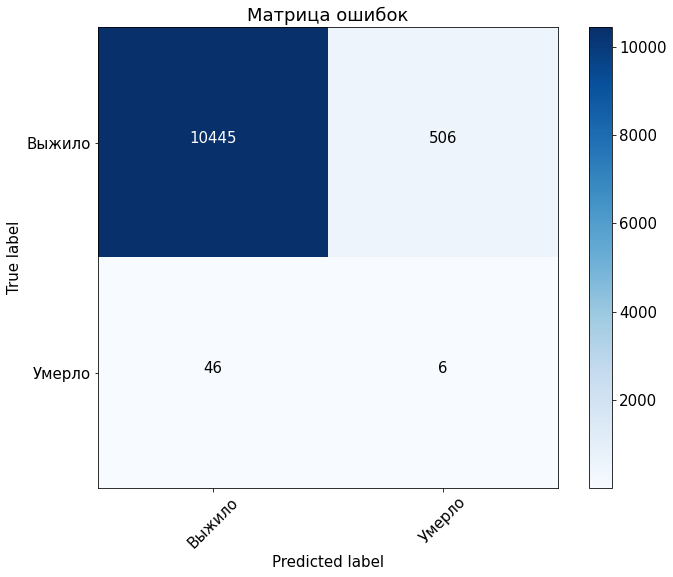

In [32]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Эта функция печатает матрицу ошибок. Если нужна норамлизация, 
    измени в функции значение`normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная матрица ошибок")
    else:
        print('Матрица ошибок без нормализации')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = metrics.confusion_matrix(val_target, y_pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Выжило', 'Умерло'],
                      title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()


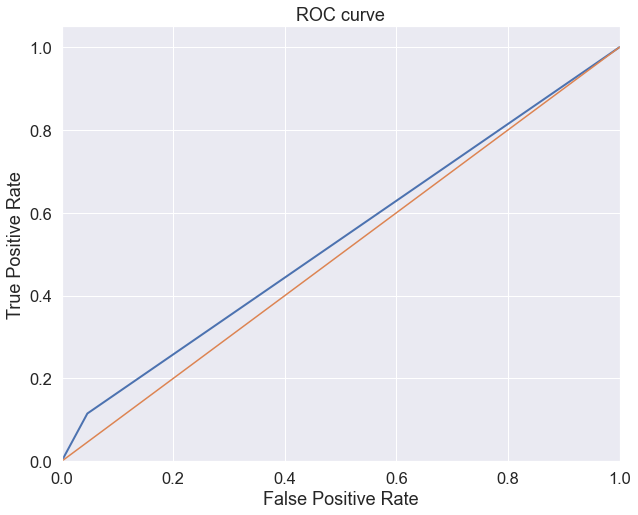

In [38]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(val_target, y_pred, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()